# Analyzing IPTA DR2 Data

In this notebook we will use `enterprise` to analyze the IPTA DR2 for a stochastic GW background using the NANOGrav 9 year data and the PPTA data that went into DR2 from the PPTA.

In [1]:
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext line_profiler

from __future__ import division

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import json

### Function to convert PAL2 noise parameters to enterprise parameter dict

In [2]:
def get_noise_from_pal2(noisefile):
    psrname = noisefile.split('/')[-1].split('_noise.txt')[0]
    fin = open(noisefile, 'r')
    lines = fin.readlines()
    params = {}
    for line in lines:
        ln = line.split()
        if 'efac' in line:
            par = 'efac'
            flag = ln[0].split('efac-')[-1]
        elif 'equad' in line:
            par = 'log10_equad'
            flag = ln[0].split('equad-')[-1]
        elif 'jitter_q' in line:
            par = 'log10_ecorr'
            flag = ln[0].split('jitter_q-')[-1]
        elif 'RN-Amplitude' in line:
            par = 'log10_A'
            flag = ''
        elif 'RN-spectral-index' in line:
            par = 'gamma'
            flag = ''
        else:
            break
        if flag:
            name = [psrname, flag, par]
        else:
            name = [psrname, par]
        pname = '_'.join(name)
        params.update({pname: float(ln[1])})
    return params

In [3]:
class JumpProposal(object):
    
    def __init__(self, pta):
        """Set up some custom jump proposals
        
        :param params: A list of `enterprise` parameters
        
        """
        self.params = pta.params
        self.npar = len(pta.params)
        self.ndim = sum(p.size or 1 for p in pta.params)
        
        # parameter map
        self.pmap = {}
        ct = 0
        for p in pta.params:
            size = p.size or 1
            self.pmap[p] = slice(ct, ct+size)
            ct += size
            
        # parameter indices map
        self.pimap = {}
        for ct, p in enumerate(pta.param_names):
            self.pimap[p] = ct
            
        self.snames = {}
        for sc in pta._signalcollections:
            for signal in sc._signals:
                self.snames[signal.signal_name] = signal.params
        
    def draw_from_prior(self, x, iter, beta):
        """Prior draw.
        
        The function signature is specific to PTMCMCSampler.
        """
        
        q = x.copy()
        lqxy = 0
        
        # randomly choose parameter
        idx = np.random.randint(0, self.npar)
        
        # if vector parameter jump in random component
        param = self.params[idx]
        if param.size:
            idx2 = np.random.randint(0, param.size)
            q[self.pmap[param]][idx2] = param.sample()[idx2]

        # scalar parameter
        else:
            q[idx] = param.sample()
        
        # forward-backward jump probability
        lqxy = param.get_logpdf(x[self.pmap[param]]) - param.get_logpdf(q[self.pmap[param]])
                
        return q, float(lqxy)
    
# utility function for finding global parameters
def get_global_parameters(pta):
    pars = []
    for sc in pta._signalcollections:
        pars.extend(sc.param_names)
    
    gpars = np.unique(filter(lambda x: pars.count(x)>1, pars))
    ipars = np.array([p for p in pars if p not in gpars])
        
    return gpars, ipars

# utility function to get parameter groupings for sampling
def get_parameter_groups(pta):
    ndim = len(pta.param_names)
    groups  = [range(0, ndim)]
    params = pta.param_names
    
    # get global and individual parameters
    gpars, ipars = get_global_parameters(pta)
    if any(gpars):
        groups.extend([[params.index(gp) for gp in gpars]])

    for sc in pta._signalcollections:
        for signal in sc._signals:
            ind = [params.index(p) for p in signal.param_names if p not in gpars]
            if ind:
                groups.extend([ind])
    
    return groups

In [4]:
#The pulsars we'll be analyzing
psrdict = {'J1713+0747': [{'pta': ['NANOGrav', 'PPTA']}], 
           'J1909-3744': [{'pta': ['NANOGrav', 'PPTA']}], 
           'J1640+2224': [{'pta': ['NANOGrav']}], 
           'J1600-3053': [{'pta': ['NANOGrav']}],
           'J2317+1439': [{'pta': ['NANOGrav']}], 
           'J1918-0642': [{'pta': ['NANOGrav']}], 
           'J1614-2230': [{'pta': ['NANOGrav']}], 
           'J1744-1134': [{'pta': ['NANOGrav', 'PPTA']}],
           'J0030+0451': [{'pta': ['NANOGrav']}], 
           'J2145-0750': [{'pta': ['NANOGrav']}], 
           'J1857+0943': [{'pta': ['NANOGrav']}], 
           'J1853+1303': [{'pta': ['NANOGrav']}], 
           'J0613-0200': [{'pta': ['NANOGrav']}],
           'J1455-3330': [{'pta': ['NANOGrav']}], 
           'J1741+1351': [{'pta': ['NANOGrav']}], 
           'J2010-1323': [{'pta': ['NANOGrav']}], 
           'J1024-0719': [{'pta': ['NANOGrav']}], 
           'J1012+5307': [{'pta': ['NANOGrav']}],
           'J0437-4715': [{'pta': ['PPTA']}]
          }
psrlist=psrdict.keys()

In [5]:
psrlist

['J1909-3744',
 'J1857+0943',
 'J1853+1303',
 'J1713+0747',
 'J1012+5307',
 'J2010-1323',
 'J1640+2224',
 'J0437-4715',
 'J1455-3330',
 'J0030+0451',
 'J0613-0200',
 'J1741+1351',
 'J1024-0719',
 'J1744-1134',
 'J2145-0750',
 'J1918-0642',
 'J2317+1439',
 'J1614-2230',
 'J1600-3053']

### Get par, tim, and noise files
Here we collect the tim and par files as well as noise files made from the `PAL2` code. These are the same par, tim, and noise files used in the 9-year analysis papers. We use the convienience function above to convert from `PAL2` noise files to `enterprise` parameter dictionaries.

In [6]:
datadir = '../ipta_dsets/partim_filtered_ppta_ng/'

In [7]:
parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))

# filter
parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

In [8]:
len(parfiles)

19

### Load into Pulsar class list

In [9]:
psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem='DE436')
    psrs.append(psr)

### Get parameter dict from noisefiles

In [10]:
noisefiles = sorted(glob.glob('../ipta_dsets/partim_filtered_ppta_ng/noisefiles_ppta_ng_normal/*.json'))

In [11]:
params = {}
for nf in noisefiles:
    with open(nf, 'r') as fin:
        params.update(json.load(fin))

### Set up model

When setting up the model for our upper limit run we fix all of the white noise (EFAC, EQUAD, and ECORR) parameters to the values obtained from the noise files. This is done by using `Constant` parameters. In this case we do not specify a default value for all instances of that parameter but instead will set them, based on their initialized pulsar and backend specific name, later via the `set_default_params` method of `PTA`. 

Speaking of white noise parameters here, we also use the `Selection` object.

Another feature to notice is that we do not use a uniform prior on the log of the red noise or GWB amplitude. Instead we use a `LinearExp` prior (short for linear-exponent prior), that is a prior of the form $p(x)\propto 10^x$. This is how we can still use the log of the parameter to sample but place a uniform prior on the parameter itself. We do this for both the red noise and GWB amplitude parameters.

Next, in order to save on computing time we do not include spatial correlations here. Instead we model the GWB as a common red process across all pulsars. In `enterprise` we can do this with a simple trick. We pre-initialize the parameters before passing them to the `Signal` model. In this way the *same* parameter instance is used for all pulsars. Lastly, we fixt the spectral index of the GWB to be 13/3 (4.33) using the `Constant` parameter.

## Setup model

We will add some addition model components that are not part of the base enterprise

### 1. Exponential decay function to model "void" in J1713+0747

In [14]:
@signal_base.function
def exp_decay(toas, freqs, log10_Amp=-7, t0=54000, log10_tau=1.7):
    t0 *= const.day
    tau = 10**log10_tau * const.day
    wf = - 10**log10_Amp * np.heaviside(toas-t0, 1) * np.exp(-(toas-t0)/tau)
    return wf * (1400/freqs)**2

### 2. Yearly DM sinusoid

In [15]:
@signal_base.function
def yearly_sinusoid(toas, freqs, log10_Amp=-7, phase=0):

    wf = 10**log10_Amp * np.sin(2*np.pi*const.fyr*toas+phase)
    return wf * (1400/freqs)**2

### 3. DM EQUAD (EQUAD) term that scales like $\nu^{-4}$ (variance remember...)

In [16]:
# define DM EQUAD variance function
@signal_base.function
def dmequad_ndiag(freqs, log10_dmequad=-8):
    return np.ones_like(freqs) * (1400/freqs)**4 * 10**(2*log10_dmequad)

### 4. SVD timing model basis
This allows for more stability over standard scaling methods

In [17]:
# SVD timing model basis
@signal_base.function
def svd_tm_basis(Mmat):
    u, s, v = np.linalg.svd(Mmat, full_matrices=False)
    return u, np.ones_like(s)

@signal_base.function
def tm_prior(weights):
    return weights * 10**40

In [ ]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

# define selection by observing backend
selection = selections.Selection(selections.by_backend)

# special selection for ECORR only use wideband NANOGrav data
selection2 = selections.Selection(selections.nanograv_backends)

# white noise parameters
# since we are fixing these to values from the noise file we set
# them as constant parameters
efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant()

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

# DM turnover parameters
kappa = parameter.Uniform(0,7)
lf0 = parameter.Uniform(-9, -6.5)

# DM exponential parameters
t0 = parameter.Uniform(psr.toas.min()/86400, psr.toas.max()/86400)
log10_Amp = parameter.Uniform(-10, -2)
log10_tau = parameter.Uniform(np.log10(5), np.log10(500))

# DM sinusoid parameters
log10_Amp_s = parameter.Uniform(-10, -2)
phase = parameter.Uniform(0, 2*np.pi)

# white noise signals

# DM EQUAD
#dmvariance = dmequad_ndiag(log10_dmequad=equad)
#dmeq = white_signals.WhiteNoise(dmvariance)

# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection2)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)


# DM GP signals (use turnover model for more flexibility)
dm_basis = utils.createfourierdesignmatrix_dm(nmodes=30)
dm_prior = utils.turnover(log10_A=log10_A, gamma=gamma, lf0=lf0, kappa=kappa)
dmgp = gp_signals.BasisGP(dm_prior, dm_basis, name='dm')


# DM exponential model
wf = exp_decay(log10_Amp=log10_Amp, t0=t0, log10_tau=log10_tau)
dmexp = deterministic_signals.Deterministic(wf, name='exp')

# DM sinusoid model
wf = yearly_sinusoid(log10_Amp=log10_Amp_s, phase=phase)
dmys = deterministic_signals.Deterministic(wf, name='s1yr')

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan)

# for spatial correltions you can do...
#orf = utils.hd_orf()
#crn = gp_signals.FourierBasisCommonGP(cpl, orf, components=30, name='gw', Tspan=Tspan)

# to add solar system ephemeris modeling...
eph = deterministic_signals.PhysicalEphemerisSignal(use_epoch_toas=True)

# timing model
basis = svd_tm_basis()
prior = tm_prior()
tm = gp_signals.BasisGP(prior, basis)
#tm = gp_signals.TimingModel()

# full model
#s = ef + eq + rn + dmgp + tm  + dmeq + dmys
s = ef + eq + rn + tm + dmgp + dmys + eph + gw #+ dmeq

# intialize PTA, adding an exponential dip for the DM event in J1713+0747
models = []

for p in psrs:    
    if 'NANOGrav' in p.flags['pta']:
        s2 = s + ec 
        if p.name == 'J1713+0747':
            s3 = s2 + dmexp
            models.append(s3(p))
        else:
            models.append(s2(p))
    else:
        models.append(s(p))
    
pta = signal_base.PTA(models)

### Set white noise parameters

In [ ]:
pta.set_default_params(params)

### Set initial parameters drawn from prior and evaluate likelihood to fill caches

Evaluating the likelihood is not necessary, the caches will be filled the first time it is called within the sampler if not called here.

In [ ]:
xs = {par.name: par.sample() for par in pta.params}
print pta.get_lnlikelihood(xs);
print pta.get_lnprior(xs);

In [26]:
params

{u'J0030+0451_430_ASP_efac': 1.1441831910573546,
 u'J0030+0451_430_ASP_log10_ecorr': -8.306510835111641,
 u'J0030+0451_430_ASP_log10_equad': -8.27390789694795,
 u'J0030+0451_430_PUPPI_efac': 0.9762900323039714,
 u'J0030+0451_430_PUPPI_log10_ecorr': -5.989300751588091,
 u'J0030+0451_430_PUPPI_log10_equad': -5.962496611939736,
 u'J0030+0451_L-wide_ASP_efac': 1.1238593431335526,
 u'J0030+0451_L-wide_ASP_log10_ecorr': -8.374193646777268,
 u'J0030+0451_L-wide_ASP_log10_equad': -8.145472412682228,
 u'J0030+0451_L-wide_PUPPI_efac': 1.1466872228655136,
 u'J0030+0451_L-wide_PUPPI_log10_ecorr': -8.505257741477394,
 u'J0030+0451_L-wide_PUPPI_log10_equad': -6.3391036599972335,
 u'J0030+0451_dm_gamma': 2.2074162520849048,
 u'J0030+0451_dm_kappa': 3.7753492904199724,
 u'J0030+0451_dm_lf0': -7.692297826333863,
 u'J0030+0451_dm_log10_A': -13.806118566137624,
 u'J0030+0451_gamma': 4.532217197705858,
 u'J0030+0451_log10_A': -14.131752830064068,
 u'J0437-4715_CPSR2_20CM_efac': 3.18902938583909,
 u'J0437-

### Set up sampler

In [11]:
# dimension of parameter space
ndim = len(xs)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# set up jump groups by red noise groups 
ndim = len(xs)
groups = get_parameter_groups(pta)

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, 
                 outDir='./chains/ipta_dr2_ng_ppta_gwb/')

### Sample!

In [ ]:
# sampler for N steps
N = 1000000
x0 = np.hstack(p.sample() for p in pta.params)
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 1.00 percent in 431.417335 s Acceptance rate = 0.6181Adding DE jump with weight 50
Finished 3.20 percent in 1446.421140 s Acceptance rate = 0.503219

### Plot output

In [4]:
chain = np.loadtxt('./chains/nano_9_gwb/chain_1.txt')
#pars = sorted(xs.keys())
burn = int(0.25 * chain.shape[0])

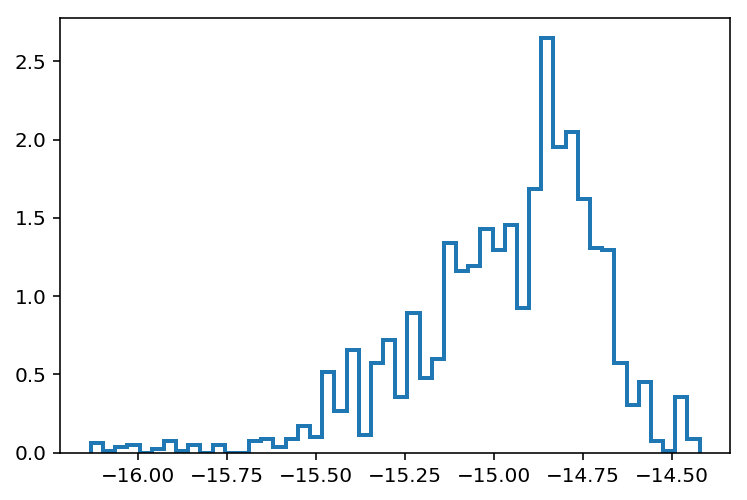

In [6]:
plt.hist(chain[burn:,-5], 50, normed=True, histtype='step', lw=2);
#plt.xlabel(pars[-1]);

### Upper limit value

We see that the upper limit agrees perfectly with the published value.

In [39]:
upper = 10**np.percentile(chain[burn:, -5], q=0.95)
print(upper)

1.49899289556e-15
